In [ ]:
!pip install kaggle

### Setting up the Kaggle environment instead of downloading the dataset

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Emotion Detection/"

Mounted at /content/drive


In [ ]:
import tensorflow
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!kaggle datasets download -d msambare/fer2013 --unzip -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 71% 43.0M/60.3M [00:00<00:00, 194MB/s] 
100% 60.3M/60.3M [00:00<00:00, 195MB/s]


In [ ]:
print(os.listdir("/content/dataset"))

['train', 'test']


In [ ]:
from tensorflow.keras.layers import MaxPooling2D , GlobalAveragePooling2D,Conv2D , BatchNormalization , Flatten , Dropout , Activation , Input ,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG , Image
from tensorflow.keras.optimizers import Adam

In [ ]:
pip install opencv-python

In [ ]:
from glob import glob
import cv2
import random

# Train Images Display

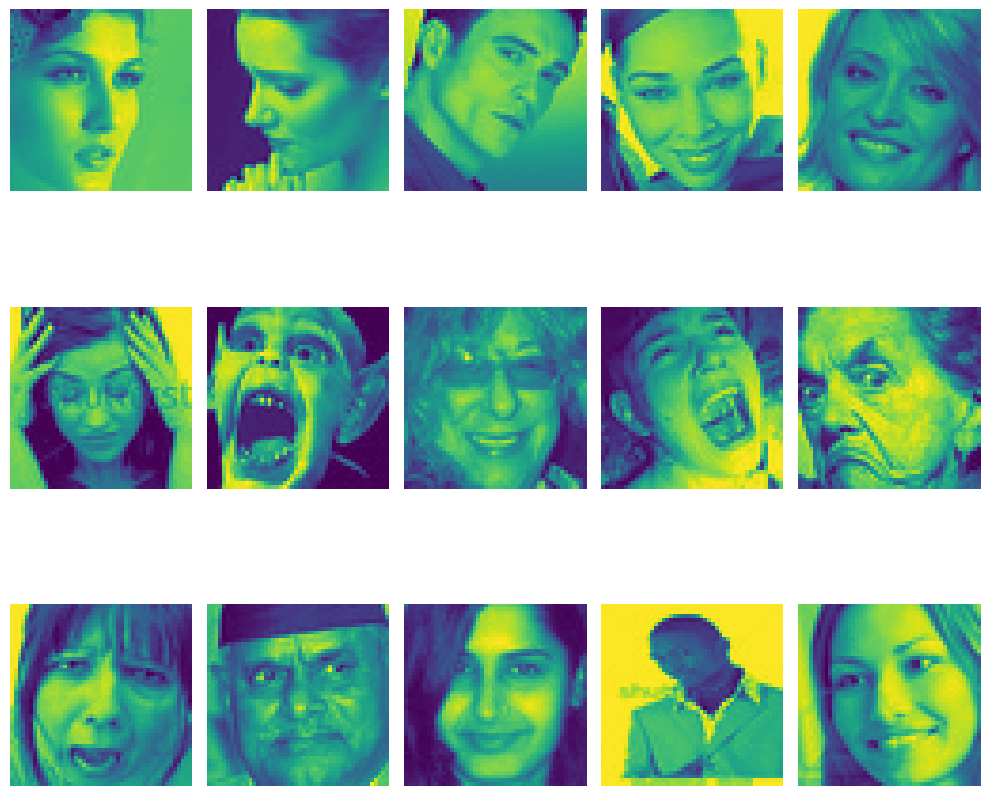

In [ ]:
train_images = glob("/content/dataset/train/**/**")
plt.figure(figsize = (10 , 10))
for i in range(15):
    image = random.choice(train_images)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

    plt.subplot(3 , 5 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Test Images Display

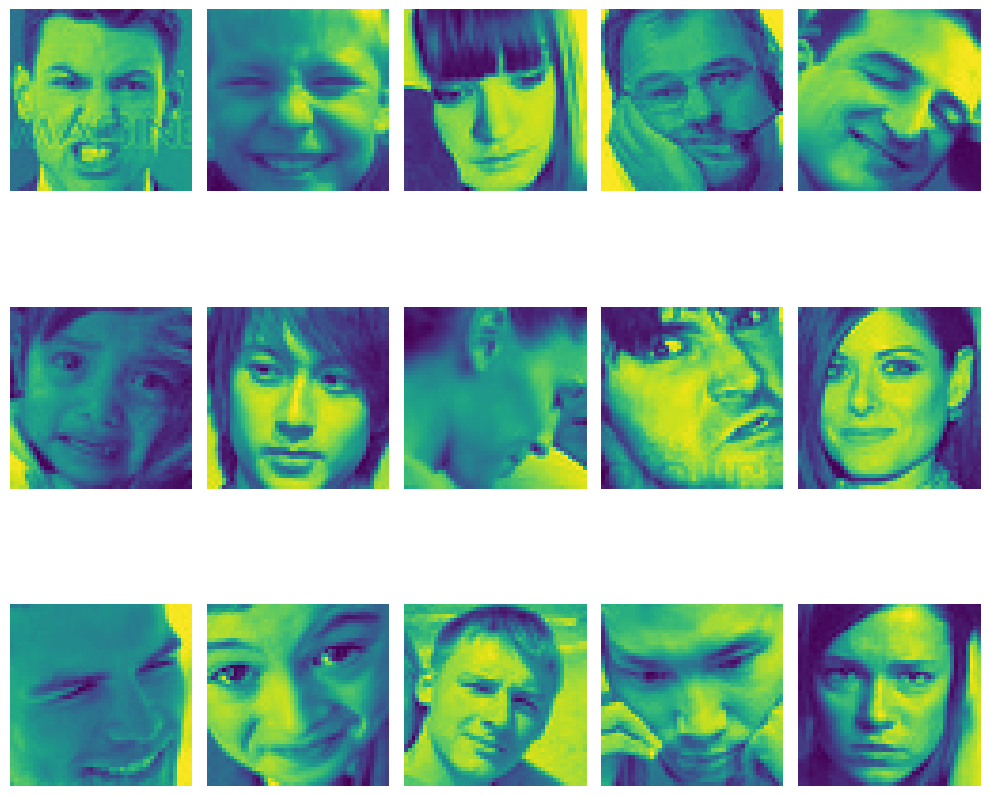

In [ ]:
test_images = glob("/content/dataset/test/**/**")
plt.figure(figsize = (10 , 10))
for i in range(15):
    image = random.choice(test_images)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

    plt.subplot(3 , 5 , i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Data Augmentation

In [ ]:
img_size = 256
batch_size = 64
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.15,
    zoom_range=0.15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.35,
    brightness_range = [0.8,1.2]
)

train_set = datagen.flow_from_directory(
    "/content/dataset/train/",
    color_mode="grayscale",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)
print("Classes Found (Training):", train_set.class_indices)
val_set = datagen.flow_from_directory(
    "/content/dataset/train/",
    color_mode="grayscale",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)
print("Classes Found (Validation):", val_set.class_indices)

datagen_test = ImageDataGenerator(rescale=1./255)
test_set = datagen_test.flow_from_directory(
    "/content/dataset/test/",
    color_mode="grayscale",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical"
)
print("Classes Found (Test):", test_set.class_indices)

Found 18665 images belonging to 7 classes.
Classes Found (Training): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Found 10044 images belonging to 7 classes.
Classes Found (Validation): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Found 7178 images belonging to 7 classes.
Classes Found (Test): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Stack CNN Model

In [ ]:
def stack_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), padding='same' , activation = 'relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3),padding='same' , activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), padding='same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), padding='same' , activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(512, (3,3), padding='same' , activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(1024, (3,3), padding='same', activation = 'relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)

    x = Dense(1024, activation = 'relu' , kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.50)(x)

    output = Dense(7, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
model = stack_model((img_size , img_size , 1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,081,095 (88.05 MB)

 Trainable params: 23,077,063 (88.03 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Model Checkpoint

In [ ]:
save_dir = "/content/drive/MyDrive/Emotion Detection/"
epoch = 60
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, "model_weights_gray_scale_16feb.weights.h5"),
    monitor="val_accuracy",
    mode="max",
    save_weights_only=True
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [checkpoint, early_stopping,lr_scheduler]

In [ ]:
history = model.fit(x = train_set,
                    verbose=1,
                    callbacks=callbacks,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=val_set
)

Epoch 1/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 230s 703ms/step - accuracy: 0.2306 - loss: 5.9425 - val_accuracy: 0.1683 - val_loss: 4.0980 - learning_rate: 3.0000e-04
Epoch 2/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 187s 639ms/step - accuracy: 0.2917 - loss: 3.7651 - val_accuracy: 0.3170 - val_loss: 3.3187 - learning_rate: 3.0000e-04
Epoch 3/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 185s 633ms/step - accuracy: 0.3420 - loss: 3.1537 - val_accuracy: 0.3950 - val_loss: 2.7458 - learning_rate: 3.0000e-04
Epoch 4/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 209s 715ms/step - accuracy: 0.3922 - loss: 2.6396 - val_accuracy: 0.4437 - val_loss: 2.2828 - learning_rate: 3.0000e-04
Epoch 5/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 182s 625ms/step - accuracy: 0.4358 - loss: 2.2770 - val_accuracy: 0.4266 - val_loss: 2.1262 - learning_rate: 3.0000e-04
Epoch 6/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 203s 629ms/step - accuracy: 0.4603 - loss: 2.0675 - val_accuracy: 0.4871 - val_loss: 1.9140 - learning_rate: 3.0000e-04
Epoch 7/60
292/292 ━━━━━━━━━━━━━━━━━━━━ 

# Evaluating the test set

In [ ]:
model.evaluate(test_set)

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6769 - loss: 1.2847


[1.2996994256973267, 0.6668988466262817]

In [ ]:
import matplotlib.pyplot as plt

## Loss Estimation

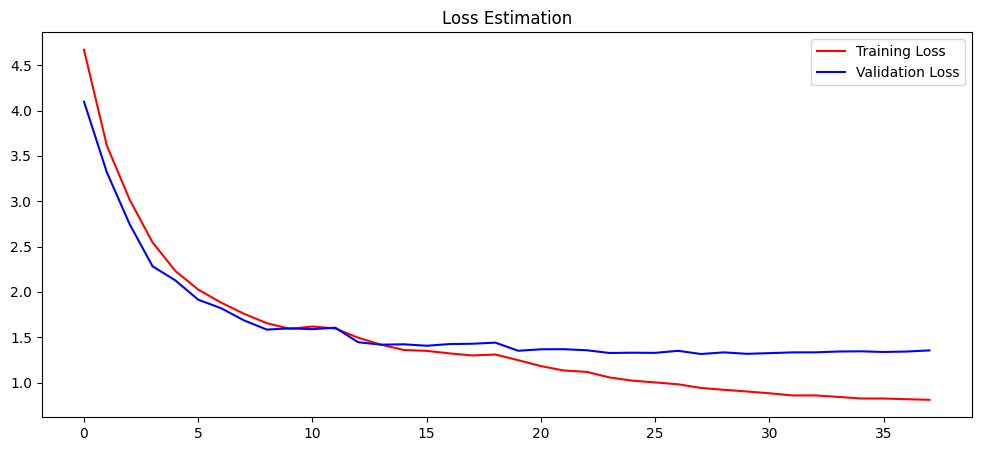

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(history.history['loss'] , color = 'red' , label = 'Training Loss')
plt.plot(history.history['val_loss'] , color = 'blue' , label = 'Validation Loss')
plt.title("Loss Estimation")
plt.legend()
plt.show()

## Accuracy Estimation

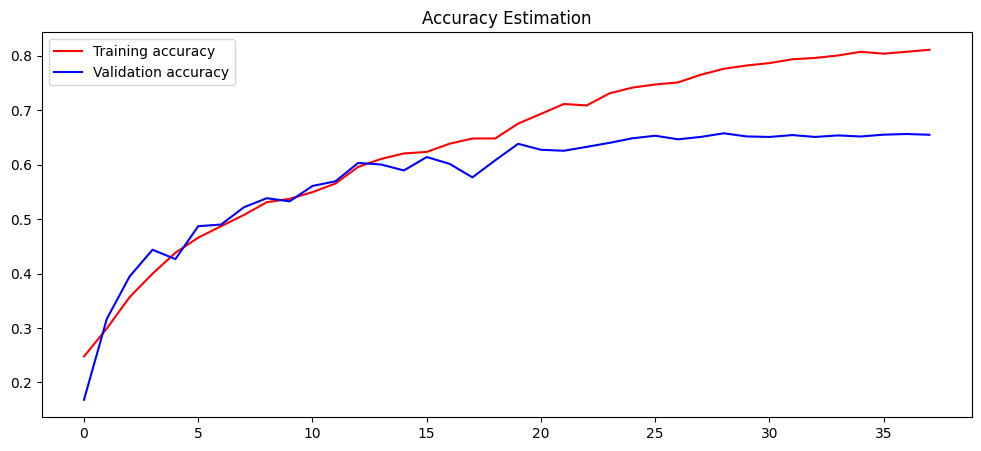

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(history.history['accuracy'] , color = 'red' , label = 'Training accuracy')
plt.plot(history.history['val_accuracy'] , color = 'blue' , label = 'Validation accuracy')
plt.title("Accuracy Estimation")
plt.legend()
plt.show()

In [ ]:
#model_json = model.to_json()
#with open("/content/drive/MyDrive/Emotion Detection/emotion_model_67perc_16feb_final_gray.json", "w") as json_file:
#    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json

# Final Enhanced Model

In [ ]:
with open("/content/drive/MyDrive/Emotion Detection/emotion_model_67perc_16feb_final_gray.json", "r") as json_file:
  loaded_model = json_file.read()

loaded_model = model_from_json(loaded_model)

loaded_model.load_weights("/content/drive/MyDrive/Emotion Detection/model_weights_gray_scale_16feb.weights.h5")

loaded_model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

test_loss, test_accuracy = loaded_model.evaluate(test_set, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6806 - loss: 1.2879
Test Accuracy: 67.21%


In [ ]:
import numpy as np

# Activation Maps

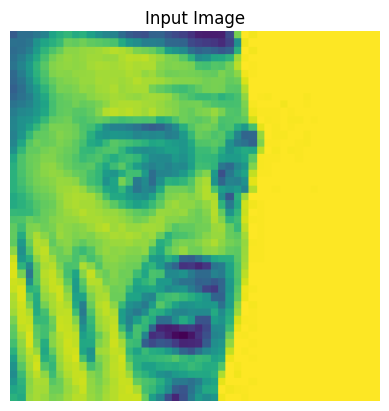

In [ ]:
img_batch , label_batch = next(test_set)
img = img_batch[0]
img = np.squeeze(img)

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [ ]:
layer_names = [layer.name for layer in loaded_model.layers if 'conv' in layer.name]
activation_model = Model(inputs=loaded_model.input,
                         outputs=[loaded_model.get_layer(name).output for name in layer_names])
img = np.expand_dims(img , axis = 0)
img = np.expand_dims(img , axis = -1)
activations = activation_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
activations

[array([[[[0.        , 0.03940282, 0.        , ..., 0.        ,
           0.01648231, 0.        ],
          [0.        , 0.04728284, 0.        , ..., 0.        ,
           0.00364982, 0.        ],
          [0.        , 0.04728284, 0.        , ..., 0.        ,
           0.00364982, 0.        ],
          ...,
          [0.        , 0.12965241, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.12965241, 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.06362034, 0.        , ..., 0.        ,
           0.07921588, 0.        ]],
 
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.05907187],
          [0.01669017, 0.0121737 , 0.        , ..., 0.        ,
           0.01015352, 0.00351927],
          [0.01669017, 0.0121737 , 0.        , ..., 0.        ,
           0.01015352, 0.00351927],
          ...,
          [0.02017454, 0.00866817, 0.        , ..., 0.        ,
   

In [ ]:
print(len(activations))

6


Layer 1 - Activation Shape: (1, 256, 256, 32)


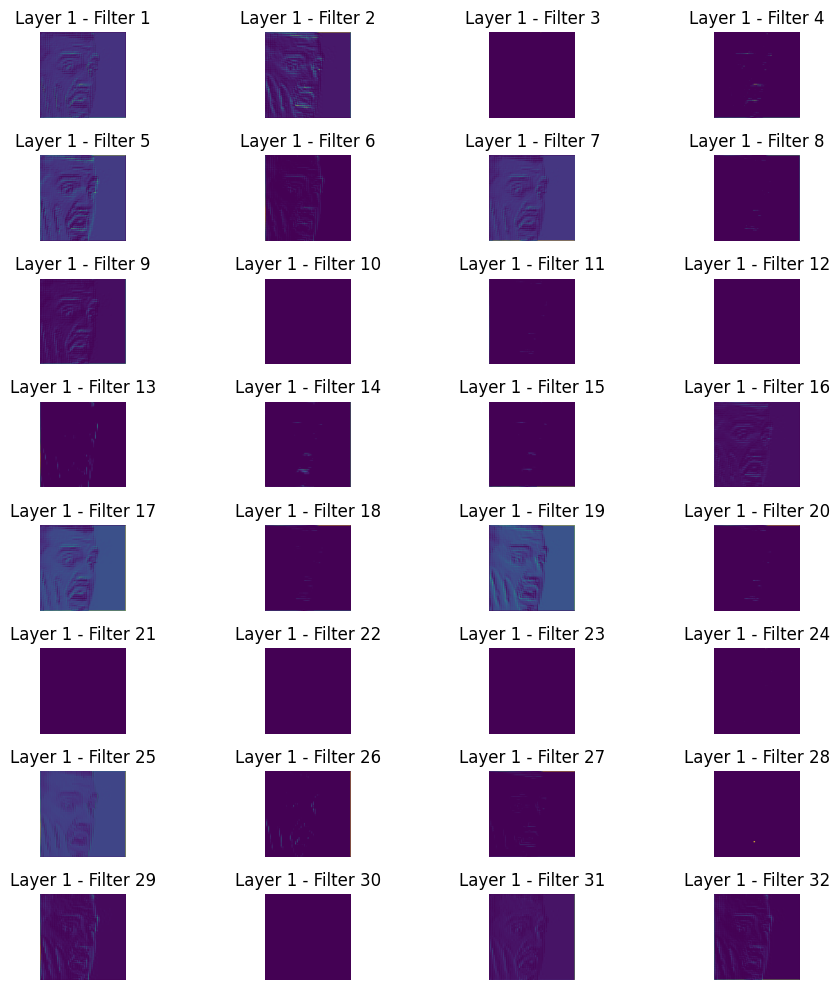

Layer 2 - Activation Shape: (1, 128, 128, 64)


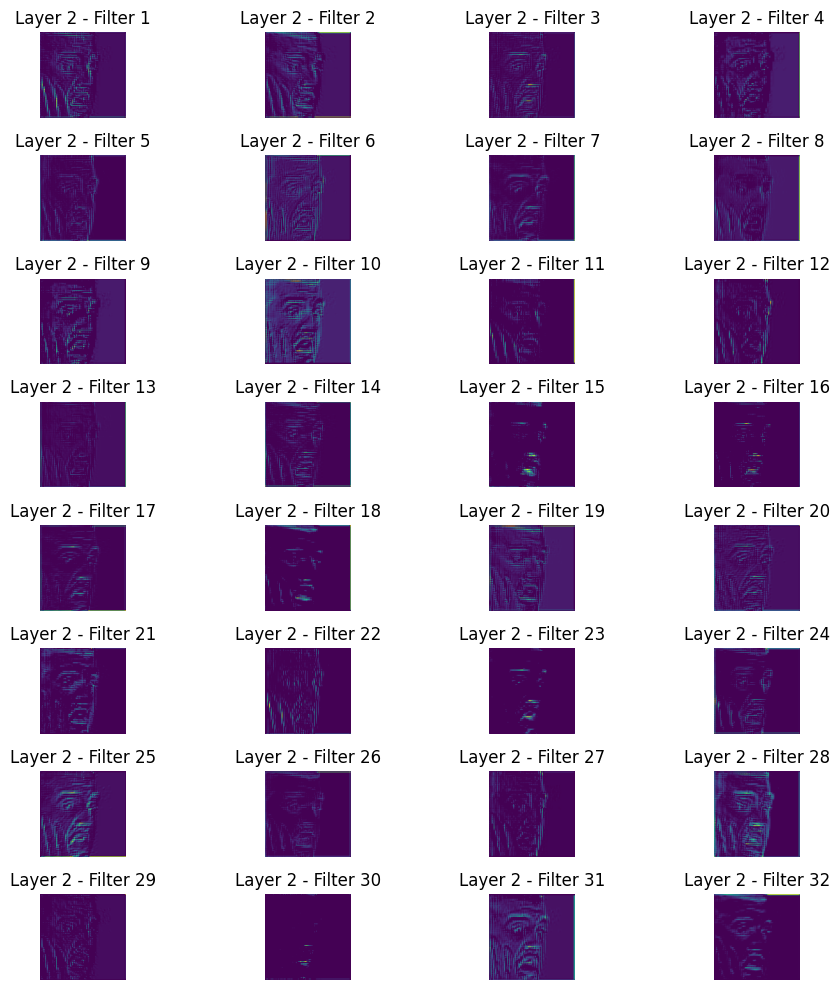

Layer 3 - Activation Shape: (1, 64, 64, 128)


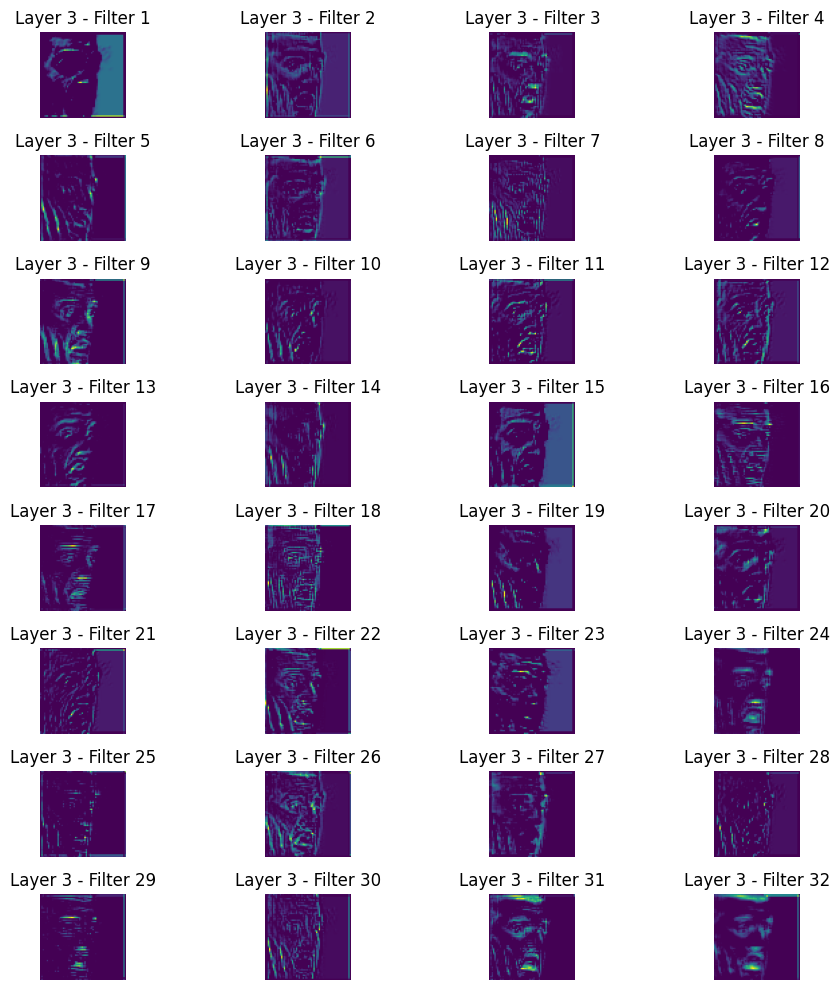

Layer 4 - Activation Shape: (1, 32, 32, 256)


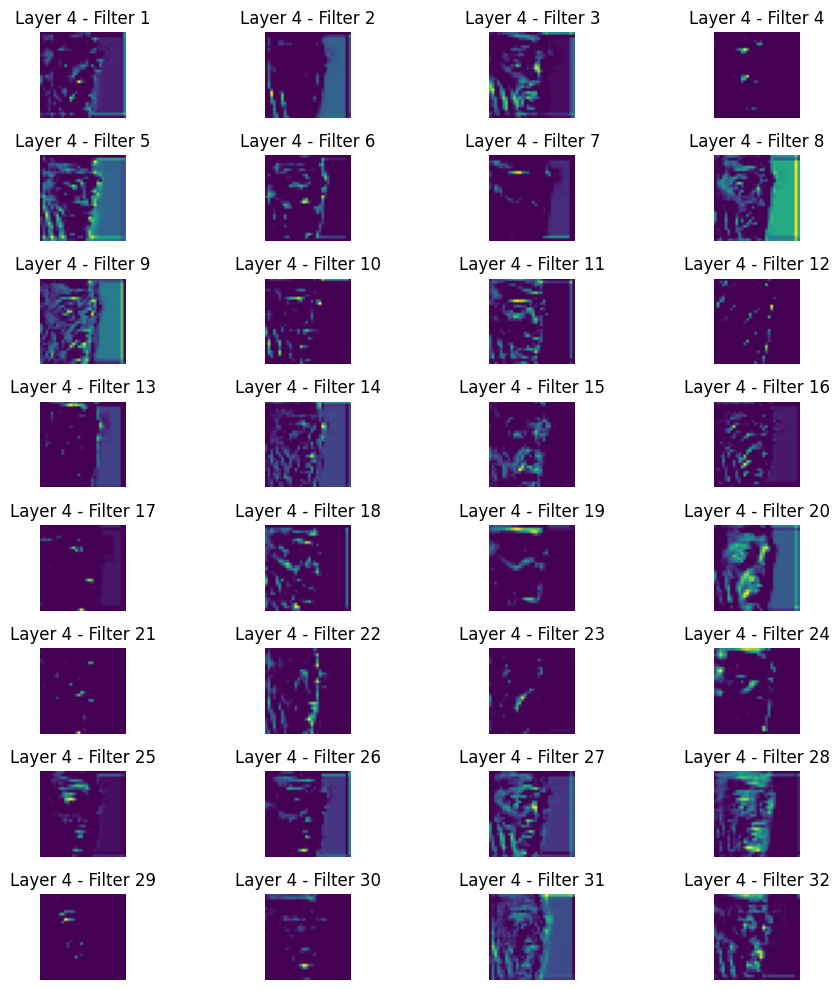

Layer 5 - Activation Shape: (1, 16, 16, 512)


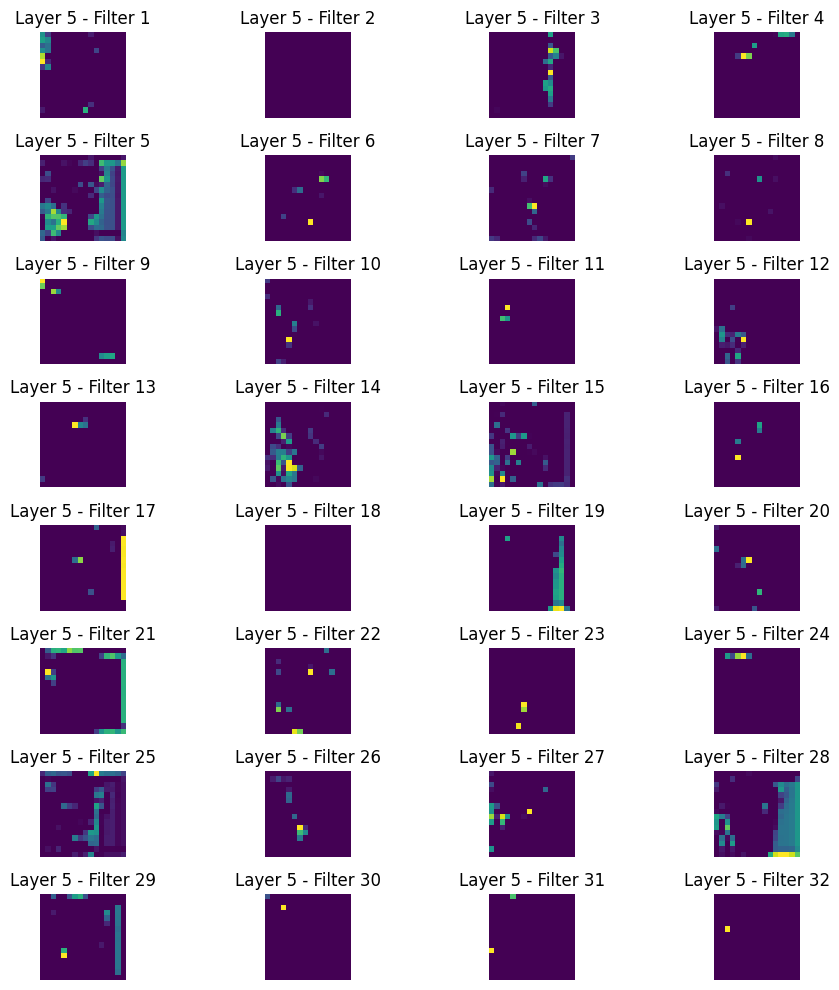

Layer 6 - Activation Shape: (1, 8, 8, 1024)


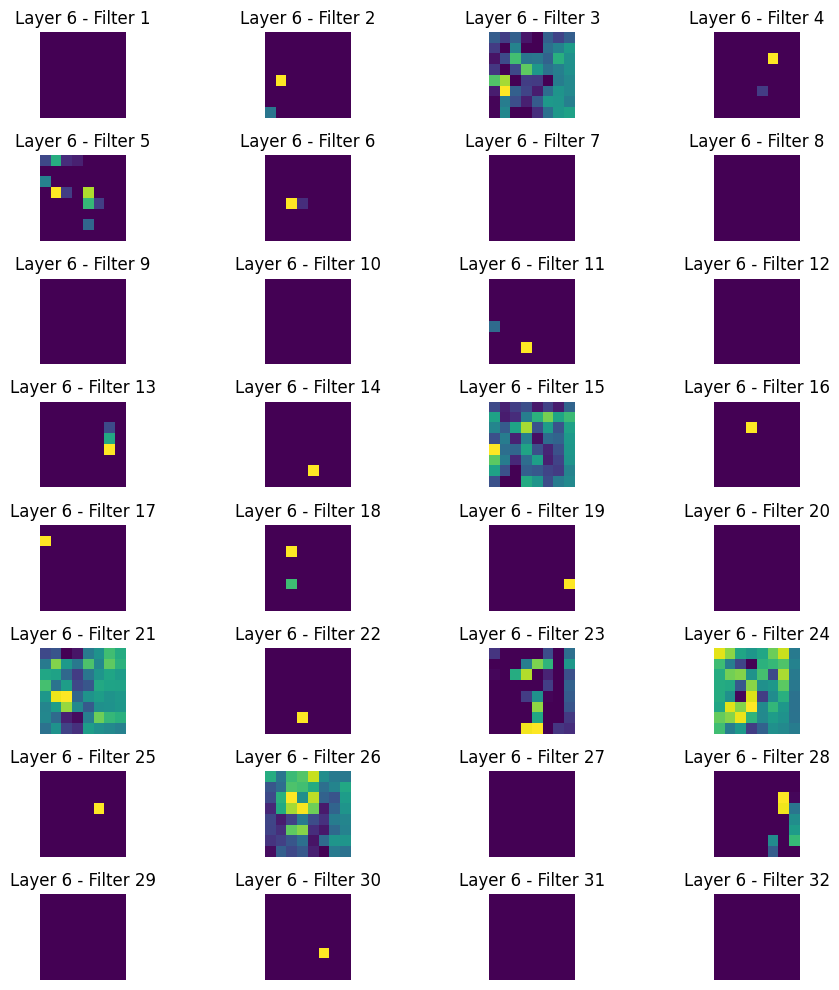

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_map(activation, layer_name, filters, size=(8, 8)):
    cols = filters // size[1]
    rows = filters // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(filters):
        ax = axes[i // cols, i % cols]

        ax.imshow(activation[0, :, :, i], cmap="viridis")
        ax.axis("off")
        ax.set_title(f"{layer_name} - Filter {i + 1}")

    plt.tight_layout()
    plt.show()

for i, activation in enumerate(activations):
    print(f"Layer {i+1} - Activation Shape: {activation.shape}")
    plot_feature_map(activation, f"Layer {i+1}", filters=32)